In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

In [2]:
rf_wrf = xr.open_dataset("/Users/dgagne/data/wrf_ml_surface/rf15/wrfout_d01_1999-10-22_19:00:00")
most_wrf = xr.open_dataset("/Users/dgagne/data/wrf_ml_surface/most4/wrfout_d01_1999-10-22_19:00:00")

In [3]:
rf_wrf.close()
most_wrf.close()

/Users/dgagne/miniconda3/envs/ml/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


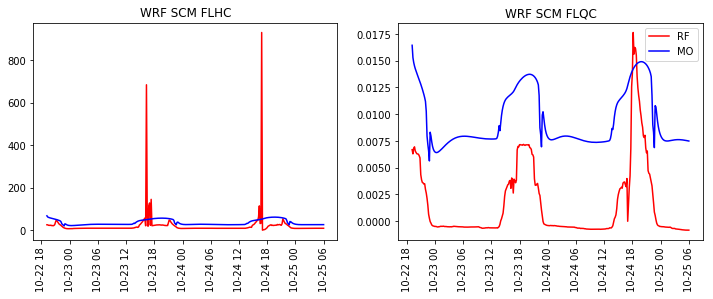

In [3]:
plt.figure(figsize=(12, 4))
time = pd.DatetimeIndex(pd.Series(rf_wrf["Times"][1:].values.astype(str)).str.replace("_", "T"))
plt.subplot(1, 2, 1)
plt.plot(time, rf_wrf["FLHC"][1:, 0, 0], 'r', label="RF")
plt.plot(time, most_wrf["FLHC"][1:, 0, 0], 'b', label="MO")
plt.title("WRF SCM FLHC")
plt.xticks(rotation=90)
plt.subplot(1, 2, 2)
plt.title("WRF SCM FLQC")
plt.plot(time, rf_wrf["FLQC"][1:, 0, 0], 'r', label="RF")
plt.plot(time, most_wrf["FLQC"][1:, 0, 0], 'b', label="MO")
plt.legend(loc=0)
plt.xticks(rotation=90)
plt.savefig("rf_mo_flhc_flqc.png", dpi=200, bbox_inches="tight")

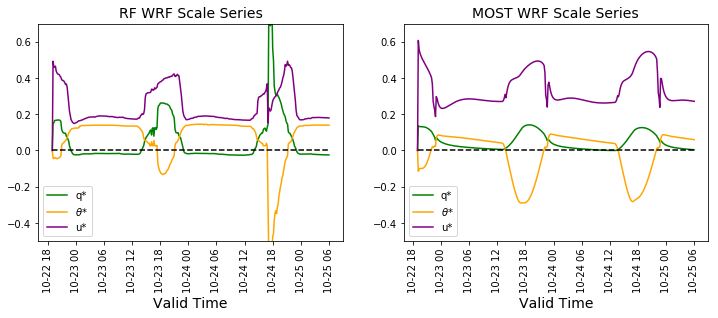

In [4]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
time = pd.DatetimeIndex(pd.Series(rf_wrf["Times"][:].values.astype(str)).str.replace("_", "T"))
plt.plot(time, rf_wrf["QSTAR"][:, 0, 0] * 1000, color="green", label="q*")
plt.plot(time, rf_wrf["MOL"][:, 0, 0], color="orange", label="$\\theta$*")
plt.plot(time, rf_wrf["UST"][:, 0, 0], color="purple", label="u*")
plt.plot(time, np.zeros(rf_wrf["UST"][:, 0, 0].size), 'k--')
plt.xlabel("Valid Time", fontsize=14)
plt.title("RF WRF Scale Series", fontsize=14)
plt.xticks(rotation=90)

plt.legend(loc=0)
plt.ylim(-0.5, 0.7)
plt.subplot(1, 2, 2)
plt.plot(time, most_wrf["QSTAR"][:, 0, 0] * 1000, color="green", label="q*")
plt.plot(time, most_wrf["MOL"][:, 0, 0], color="orange", label="$\\theta$*")
plt.plot(time, most_wrf["UST"][:, 0, 0], color="purple", label="u*")
plt.plot(time, np.zeros(rf_wrf["UST"][:, 0, 0].size), 'k--')
plt.xlabel("Valid Time", fontsize=14)
plt.xticks(rotation=90)
plt.title("MOST WRF Scale Series", fontsize=14)
plt.legend(loc=0)
plt.ylim(-0.5, 0.7)
plt.savefig("rf_mo_scale_series.png", dpi=200, bbox_inches="tight")



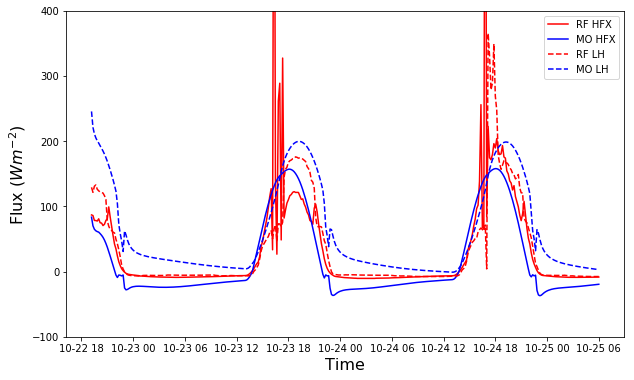

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(rf_wrf["XTIME"][1:], rf_wrf["HFX"][1:, 0, 0], "r-", label="RF HFX")
plt.plot(most_wrf["XTIME"][1:], most_wrf["HFX"][1:, 0, 0], "b-", label="MO HFX")
plt.plot(rf_wrf["XTIME"][1:], rf_wrf["LH"][1:, 0, 0], "r--", label="RF LH")
plt.plot(most_wrf["XTIME"][1:], most_wrf["LH"][1:, 0, 0], "b--", label="MO LH")
plt.legend()
plt.ylim(-100, 400)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Flux ($W m^{-2}$)", fontsize=16)
plt.savefig("wrf_flux_comp.png", dpi=200, bbox_inches="tight")

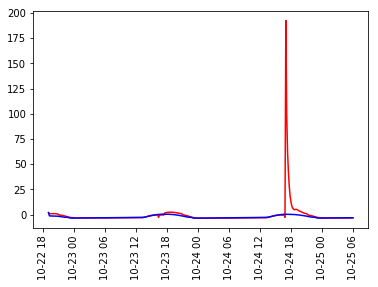

In [6]:
time = pd.DatetimeIndex(pd.Series(rf_wrf["Times"][:].values.astype(str)).str.replace("_", "T"))
plt.plot(time, rf_wrf["TSK"][:, 0, 0] - (rf_wrf["T"][:, 0, 0, 0] + 300), 'r-', label="RF")
plt.plot(time, most_wrf["TSK"][:, 0, 0] - (most_wrf["T"][:, 0, 0, 0] + 300), 'b-', label="MO")
plt.xticks(rotation=90)
plt.savefig("tdiff_comp.png", dpi=200, bbox_inches="tight")

(119, 355)
(119, 355)
(120, 355)
(59, 355)


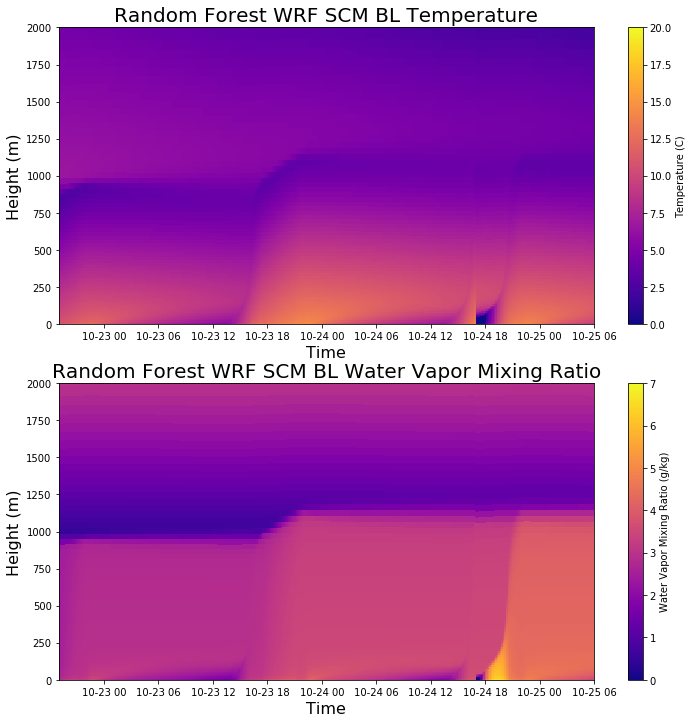

In [11]:
plt.figure(figsize=(12, 12))
pres = (rf_wrf["P"][:, :, 0, 0].T  +rf_wrf["PB"][:, :, 0, 0].T)
height = (rf_wrf["PH"][:, :, 0, 0].T + rf_wrf["PHB"][:, :, 0, 0].T) / 9.81
temperature = ((rf_wrf["T"][:, :, 0, 0].T + 300) * ( pres/ 100000.0) ** (2. / 7.)) - 273
moisture = rf_wrf["QVAPOR"][:, :, 0, 0].T * 1000
wspd = np.sqrt(rf_wrf["U"][:, :, 0, 0].T ** 2 + rf_wrf["V"][:, :, 0, 0].T ** 2)
print(temperature.shape)
print(wspd.shape)
print(height.shape)
time_tile = np.tile(rf_wrf["XTIME"].values.reshape(-1, 1), 59).T
print(time_tile.shape)
plt.subplot(2, 1, 1)
plt.pcolormesh(pd.DatetimeIndex(rf_wrf["XTIME"].values), 
               height, 
               temperature, vmin=0, vmax=20, cmap="plasma")
plt.ylim(0, 2000)
plt.ylabel("Height (m)", fontsize=16)
plt.xlabel("Time", fontsize=16)
plt.title("Random Forest WRF SCM BL Temperature", fontsize=20)
plt.colorbar(label="Temperature (C)")
plt.subplot(2, 1, 2)

plt.pcolormesh(pd.DatetimeIndex(rf_wrf["XTIME"].values), 
               height, 
               moisture, vmin=0, vmax=7, label="Water Vapor Mixing Ratio", cmap="plasma")
plt.ylim(0, 2000)
plt.ylabel("Height (m)", fontsize=16)
plt.xlabel("Time", fontsize=16)
plt.title("Random Forest WRF SCM BL Water Vapor Mixing Ratio", fontsize=20)
plt.colorbar(label="Water Vapor Mixing Ratio (g/kg)")
plt.savefig("rf_wrf_temp_moisture_rf15.png", dpi=200, bbox_inches="tight")

(119, 355)
(119, 355)
(119, 355)
(59, 355)


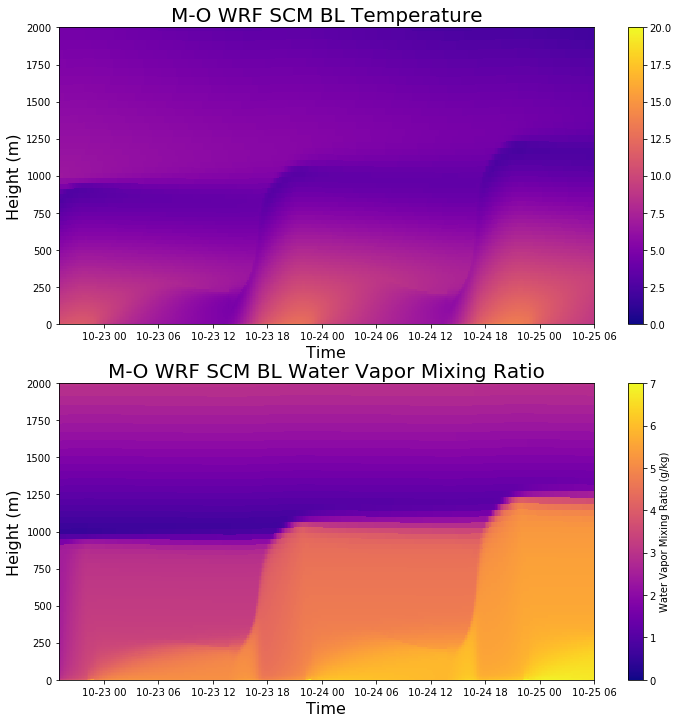

In [50]:
plt.figure(figsize=(12, 12))
pres = (most_wrf["P"][:, :, 0, 0].T  +most_wrf["PB"][:, :, 0, 0].T)
height = (most_wrf["PH"][:, :-1, 0, 0].T + most_wrf["PHB"][:, :-1, 0, 0].T) / 9.81
temperature = ((most_wrf["T"][:, :, 0, 0].T + 300) * ( pres/ 100000.0) ** (2. / 7.)) - 273
moisture = most_wrf["QVAPOR"][:, :, 0, 0].T * 1000
wspd = np.sqrt(most_wrf["U"][:, :, 0, 0].T ** 2 + most_wrf["V"][:, :, 0, 0].T ** 2)
print(temperature.shape)
print(wspd.shape)
print(height.shape)
time_tile = np.tile(rf_wrf["XTIME"].values.reshape(-1, 1), 59).T
print(time_tile.shape)
plt.subplot(2, 1, 1)
plt.pcolormesh(pd.DatetimeIndex(rf_wrf["XTIME"].values), 
               height, 
               temperature, vmin=0, vmax=20, cmap="plasma")
plt.ylim(0, 2000)
plt.ylabel("Height (m)", fontsize=16)
plt.xlabel("Time", fontsize=16)
plt.title("M-O WRF SCM BL Temperature", fontsize=20)
plt.colorbar()
plt.subplot(2, 1, 2)

plt.pcolormesh(pd.DatetimeIndex(rf_wrf["XTIME"].values), 
               height, 
               moisture, vmin=0, vmax=7, label="Water Vapor Mixing Ratio", cmap="plasma")
plt.ylim(0, 2000)
plt.ylabel("Height (m)", fontsize=16)
plt.xlabel("Time", fontsize=16)
plt.title("M-O WRF SCM BL Water Vapor Mixing Ratio", fontsize=20)
plt.colorbar(label="Water Vapor Mixing Ratio (g/kg)")
plt.savefig("most_wrf_temp_moisture.png", dpi=200, bbox_inches="tight")


In [49]:
def saturation_vapor_pressure(temperature_K):
    """
    Calculate saturation vapor pressure from Clausius-Clapeyron equation in A First Course in
    Atmospheric Thermodynamics by Grant W. Petty

    Args:
        temperature_K: Temperature in Kelvin

    Returns:
        saturation vapor pressure in hPa
    """
    Rv = 461.0
    T0 = 273.0
    es0 = 6.11
    L = 2.5e6
    return es0 * np.exp(L / Rv * (1 / T0 - 1 / temperature_K))
def saturation_mixing_ratio(temperature_K, pressure_hPa):
    """
    Calculate saturation mixing ratio from temperature and pressure

    Args:
        temperature_K: temperature in Kelvin
        pressure_hPa: pressure in hPA

    Returns:
        saturation mixing ratio in g kg-1
    """
    es = saturation_vapor_pressure(temperature_K)
    epsilon = 0.622
    return epsilon * es / (pressure_hPa - es) * 1000.0

saturation_mixing_ratio(most_wrf["TSK"][5, 0, 0], most_wrf["PSFC"][5, 0, 0] / 100) / 1000


<xarray.DataArray ()>
array(0.009358)
Coordinates:
    XLAT     float32 37.6
    XLONG    float32 -96.7
    XTIME    datetime64[ns] 1999-10-22T19:50:00

(0, 0.003)

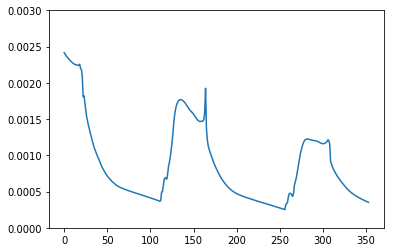

In [15]:
plt.plot(rf_wrf["QVAPOR"][1:, 0, 0, 0].T)
plt.ylim(0, 0.003)

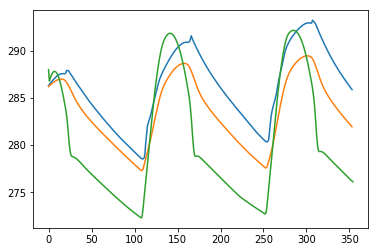

In [12]:
plt.plot(rf_wrf["T"][1:, 0, 0, 0] + 300)
plt.plot(most_wrf["T"][1:, 0, 0, 0] + 300)

#plt.plot(rf_wrf["TH2"][1:,0, 0])
#plt.plot(rf_wrf["T2"][1:, 0, 0])
#plt.plot(rf_wrf["TSK"][0:, 0, 0])
plt.plot(most_wrf["TSK"][0:, 0, 0])


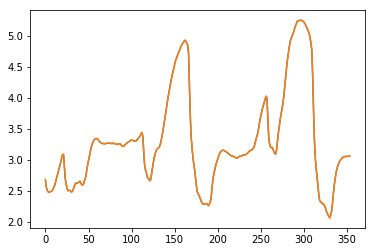

In [11]:
plt.plot(rf_wrf["U"][1:, 0, 0, 0])
plt.plot(rf_wrf["U10"][1:, 0, 0])

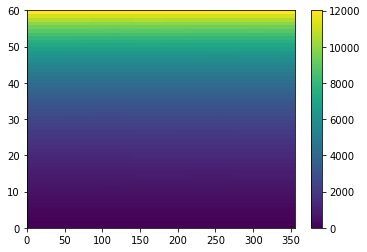

In [6]:
plt.pcolormesh((rf_wrf["PH"][:, :, 0, 0].T + rf_wrf["PHB"][:, :, 0, 0].T) / 9.81)
plt.colorbar()

(200, 310)

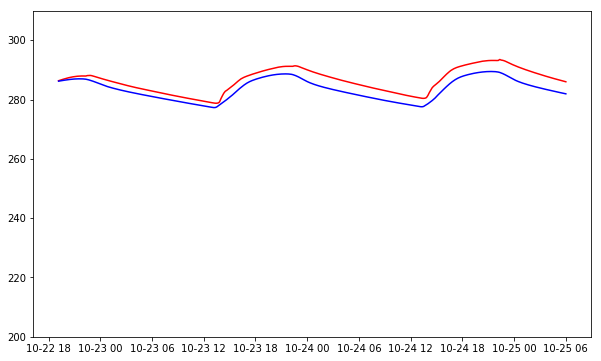

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(pd.DatetimeIndex(rf_wrf["XTIME"].values[1:]), rf_wrf["T"][1:, 0, 0, 0] + 300, 'r-')
plt.plot(pd.DatetimeIndex(most_wrf["XTIME"].values[1:]), most_wrf["T"][1:, 0, 0, 0] + 300, 'b-')
plt.ylim(200, 310)

(0, 5)

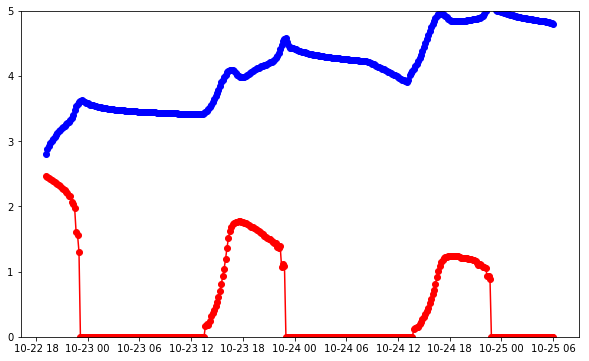

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(pd.DatetimeIndex(rf_wrf["XTIME"].values[1:]), rf_wrf["Q2"][1:, 0, 0] * 1000, 'ro-')
plt.plot(pd.DatetimeIndex(most_wrf["XTIME"].values[1:]), most_wrf["Q2"][1:, 0, 0] * 1000, 'bo-')
plt.ylim(0, 5)

(730049.7986111111, 730052.25)

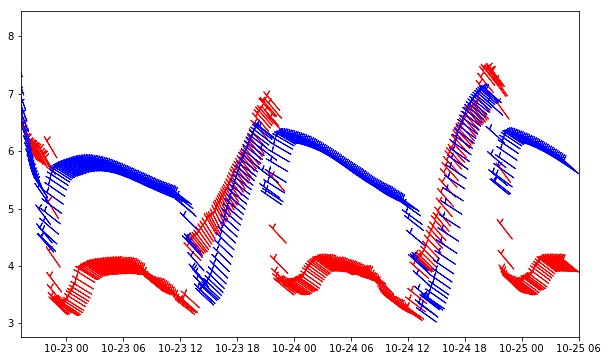

In [12]:
rf_wspd = np.sqrt(rf_wrf["U"][1:, 0, 0, 0] ** 2 + rf_wrf["V"][1:, 0, 0, 0] ** 2)
most_wspd = np.sqrt(most_wrf["U"][1:, 0, 0, 0] ** 2 + most_wrf["V"][1:, 0, 0, 0] ** 2)
times = pd.DatetimeIndex(most_wrf["XTIME"].values[1:])
plt.figure(figsize=(10, 6))
plt.barbs(times, rf_wspd, 
          rf_wrf["U10"][1:, 0, 0], rf_wrf["V10"][1:, 0, 0], color='r')
plt.barbs(times, most_wspd, 
          most_wrf["U10"][1:, 0, 0], most_wrf["V10"][1:, 0, 0], color='b')
plt.xlim(times.min(), times.max())

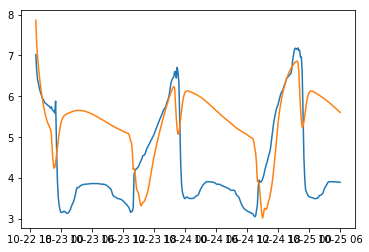

In [13]:
plt.plot(times, np.sqrt(rf_wrf["U"][1:,0, 0, 0] ** 2 + rf_wrf["V"][1:,0, 0, 0] ** 2 ))
plt.plot(times, np.sqrt(most_wrf["U"][1:,0, 0, 0] ** 2 + most_wrf["V"][1:,0, 0, 0] ** 2 ))

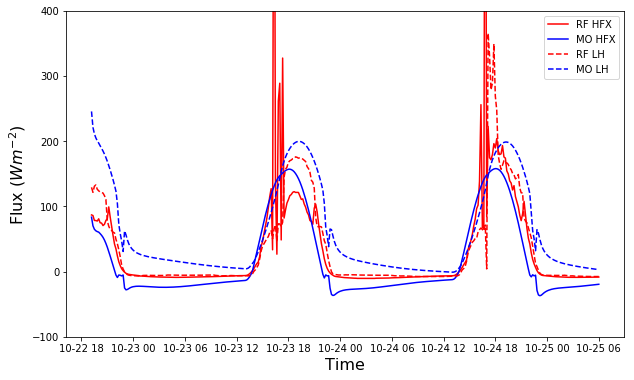

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(rf_wrf["XTIME"][1:], rf_wrf["HFX"][1:, 0, 0], "r-", label="RF HFX")
plt.plot(most_wrf["XTIME"][1:], most_wrf["HFX"][1:, 0, 0], "b-", label="MO HFX")
plt.plot(rf_wrf["XTIME"][1:], rf_wrf["LH"][1:, 0, 0], "r--", label="RF LH")
plt.plot(most_wrf["XTIME"][1:], most_wrf["LH"][1:, 0, 0], "b--", label="MO LH")
plt.legend()
plt.ylim(-100, 400)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Flux ($W m^{-2}$)", fontsize=16)
plt.savefig("wrf_flux_comp.png", dpi=200, bbox_inches="tight")

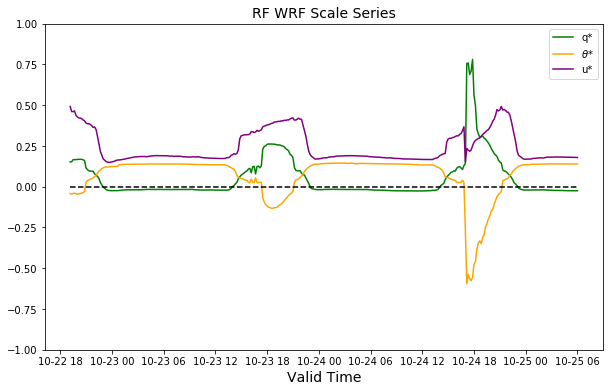

In [9]:
plt.figure(figsize=(10, 6))
time = pd.DatetimeIndex(pd.Series(rf_wrf["Times"][1:].values.astype(str)).str.replace("_", "T"))
plt.plot(time, rf_wrf["QSTAR"][1:, 0, 0] * 1000, color="green", label="q*")
plt.plot(time, rf_wrf["MOL"][1:, 0, 0], color="orange", label="$\\theta$*")
plt.plot(time, rf_wrf["UST"][1:, 0, 0], color="purple", label="u*")
plt.plot(time, np.zeros(rf_wrf["UST"][1:, 0, 0].size), 'k--')
plt.xlabel("Valid Time", fontsize=14)
plt.title("RF WRF Scale Series", fontsize=14)
plt.legend(loc=0)
plt.ylim(-1, 1)
plt.savefig("rf_scale_series.png", dpi=200, bbox_inches="tight")

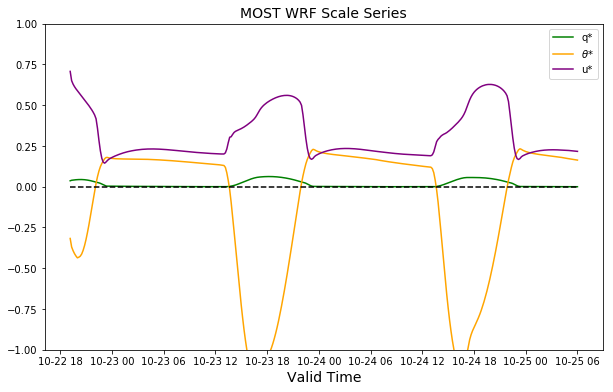

In [32]:
plt.figure(figsize=(10, 6))
time = pd.DatetimeIndex(pd.Series(most_wrf["Times"][1:].values.astype(str)).str.replace("_", "T"))
plt.plot(time, most_wrf["QSTAR"][1:, 0, 0] * 1000, color="green", label="q*")
plt.plot(time, most_wrf["MOL"][1:, 0, 0], color="orange", label="$\\theta$*")
plt.plot(time, most_wrf["UST"][1:, 0, 0], color="purple", label="u*")
plt.plot(time, np.zeros(rf_wrf["UST"][1:, 0, 0].size), 'k--')
plt.xlabel("Valid Time", fontsize=14)
plt.title("MOST WRF Scale Series", fontsize=14)
plt.legend(loc=0)
plt.ylim(-1, 1)
plt.savefig("most_scale_series.png", dpi=200, bbox_inches="tight")

In [31]:
chs_rf = pd.read_csv("../../data/wrf_ml_surface/chs_rf.tbl",delim_whitespace=True, header=None)
chs_mo = pd.read_csv("../../data/wrf_ml_surface/chs_most.tbl",delim_whitespace=True, header=None)


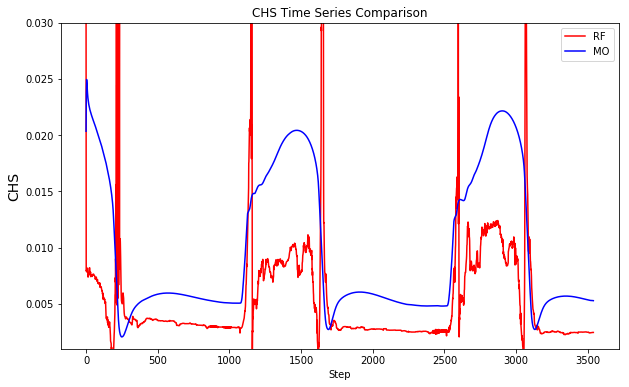

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(chs_rf[2], color="red", label="RF")
plt.plot(chs_mo[2], color="blue", label="MO")
plt.ylim(0.001, 0.03)
plt.ylabel("CHS", fontsize=14)
plt.xlabel("Step")
plt.legend()
plt.title("CHS Time Series Comparison")
plt.savefig("chs_ts.png", bbox_inches="tight")
#plt.gca().set_yscale("log")

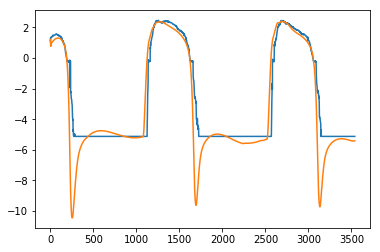

In [37]:
plt.plot(chs_rf[3])
plt.plot(chs_mo[3])

(-10, 25)

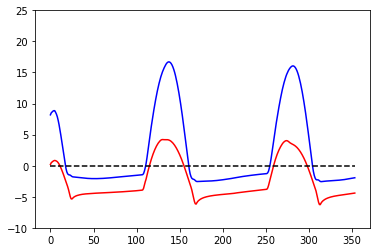

In [7]:
t_diff = most_wrf["TSK"][1:, 0, 0] - (most_wrf["T"][1:, 0, 0, 0] + 300)
sh = most_wrf["HFX"][1:, 0, 0]
plt.plot(t_diff, 'r-')
plt.plot(sh / 10, 'b-')
plt.plot(np.arange(sh.size), np.zeros(sh.size), 'k--')
plt.ylim(-10, 25)

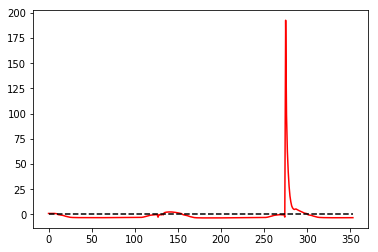

In [10]:
t_diff = rf_wrf["TSK"][1:, 0, 0] - (rf_wrf["T"][1:, 0, 0, 0] + 300)
sh = rf_wrf["HFX"][1:, 0, 0]
plt.plot(t_diff, 'r-')
#plt.plot(sh / 10, 'b-')
plt.plot(np.arange(sh.size), np.zeros(sh.size), 'k--')

#plt.ylim(-10, 25)